# A Polynomial Regression Analysis of PBSB Artwork Data
This analysis uses ploynomial regression to answer the following questions: 1. Can we estimate the price of a portrait and, 2. Can we estimate how long a portrait will take to complete?

Data wrangling performed in previous analyses is repeated here with minimal explanation. Some additional pre-processing of the input data was done in Excel. This dataset uses data at the order line level of detail which gives better visibility into individual pieces of art.

## Import libraries

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import squarify

# Machine learning and logistic regression libraries
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


## Import Excel file

In [20]:
# Define the URL of the dataset - in this case we are using a dataset that has been uploaded to OneDrive and shared
#file_path = 'C:\\Users\\simon\\OneDrive\\Documents\\Data Analysis\\Art\\Artwork-Items.xlsx'

# Load the dataset into a DataFrame
df = pd.read_excel('Artwork-Items-Reg.xlsx')

# Display the first few rows to ensure it loaded correctly
df.head()

,CustomerID,PortraitID,ServiceType,PortraitSubject,NumSubjects,Medium,SaleDate,Size,Frame,CompletedDate,ActualTime,Price,PromisedBy
0,8,10,Commission,People,1.0,Graphite,2003-04-01,11x14,NaN,2003-04-15,16,0.0,2003-04-15
1,6,12,Commission,House/dwelling,1.0,Pen & Ink / Watercolor,2003-04-01,11x14,NaN,NaT,5,0.0,NaT
2,26,62,Commission,Dog,1.0,Acrylic,2003-10-06,11x14,NaN,2003-11-09,4,0.0,2003-11-30
3,68,116,Commission,Dog,1.0,Pastel,2004-10-10,16x20,NaN,NaT,0,0.0,NaT
4,86,137,Commission,Dog,1.0,Oil,2005-06-08,24x30,NaN,NaT,0,0.0,2005-09-30


## Basic Data Cleanup
Unlike the price data used in previous analyses, the item price data is already formatted as a number and doesn't need further manipulation. There are still some rows with missing values which must be removed.

In [21]:
# Drop the rows with no order date and no sale type
df = df.dropna(subset=['SaleDate'])

In [22]:
# Filter out rows with 'Price' == 0 or 'ActualTime' == 0
df = df[(df['Price'] > 100)]
df = df[(df['ActualTime'] > 0)]

In [23]:
# Filter out any records which dont have 'ServiceType' == 'Commission' or 'ServiceType' == 'Artwork sale'
df = df[(df['ServiceType'] == 'Commission') | (df['ServiceType'] == 'Artwork sale')] 

In [24]:
df.head()

,CustomerID,PortraitID,ServiceType,PortraitSubject,NumSubjects,Medium,SaleDate,Size,Frame,CompletedDate,ActualTime,Price,PromisedBy
114,311,624,Artwork sale,NaN,0.0,NaN,2019-11-10 00:00:00,6x12,Framed,2019-03-31,8,113.53,NaT
116,208,304,Artwork sale,Landscape,0.0,Oil,2011-10-02 15:15:15,18x28,NaN,2010-08-31,20,120.00,NaT
117,215,370,Artwork sale,Landscape,0.0,Oil,2014-05-25 15:44:54,6x8,NaN,2014-03-30,2,120.00,NaT
118,21,68,Commission,Person,1.0,Color Pencil,2003-11-15 00:00:00,8x10,NaN,2003-12-07,8,125.00,2003-12-15
120,254,383,Artwork sale,Landscape,0.0,Oil,2014-06-22 09:16:00,10x8,NaN,2014-06-15,4,125.00,NaT


## Data Transformation

The source data has been cleaned up since previous analyses and obvious outliers were corrected.

### Extract 'Year'
Since the SaleDate column is already in date/time format, the Year can be extracted directly.

In [25]:
# Create a Year column
df['Year'] = df['SaleDate'].dt.year.astype(int)

### Calculate 'Area' for each item where possible
Use data in the 'Size' column to calculate the area of each painting in square incheas.

In [26]:
# Function to calculate area from 'Size' column
def calculate_area(size):
    if pd.isna(size):
        return None  
    try:
        # Convert the value to a string
        size_str = str(size)
        # Use regular expression to find the first pair of numbers (including decimals)
        match = re.search(r'(\d+(\.\d+)?)\s*[xX*]\s*(\d+(\.\d+)?)', size_str)
        if match:
            height, width = map(float, match.groups()[::2])  # Extract only the numeric parts
            return height * width
        else:
            return None  # Handle cases where the size format is incorrect
    except ValueError:
        return None  # Handle cases where the size format is incorrect

# Apply the function to the 'Size' column and create a new 'Area' column
df['Area'] = df['Size'].apply(calculate_area)

# Display the DataFrame with the new 'Area' column
print(df['Area'].head())



114     72.0
116    504.0
117     48.0
118     80.0
120     80.0
Name: Area, dtype: float64


### Remove Records With 'Area' == null

In [27]:
# Drop any records that don't have a useable 'Area'
df = df.dropna(subset=['Area'])

### Create a Price Per Hour Feature and a Price Per Area Feature

In [28]:
df['Price_Per_Hour'] = df['Price']/df['ActualTime']
df['Price_Per_Area'] = df['Price']/df['Area']

### Separate Out Commissioned Portraits
Create a dataframe that only contains commissioned paintings.

In [29]:
df_commission = df[df['ServiceType'] == 'Commission']
df_retail = df[df['ServiceType'] == 'Artwork sale']

### Drop Commission Records with Missing Dates

In [30]:
# drop any commission records with missing dates
df_commission = df_commission.dropna(subset=['CompletedDate'])

### Filter Out Mediums Other Than Oil and Pastel
The choice of medium has an impact on pricing and time taken to complete. We're just interested in oil and pastel portraits for this analysis as they make up the bulk of the studio output.

In [31]:
# Filter out values that don't start with 'Oil' or 'Pastel'
df_commission = df_commission[df_commission['Medium'].str.match(r'^(Oil|Pastel)', na=False)]

### Remove Commission Records With no Subjects

In [32]:
df_commission = df[df['NumSubjects'] > 0]

## Linear Multi Regression

### Can We Predict the Price of a Dog Portrait?
As I explained in the previous anaysis, I tend to price portraits based on a combination of my historical data and a rough assessment of how difficult I assess they will be to complete. Again, in the absence of a 'difficulty' rating, we'll examine the correlation between year, area, number of subjects and price. This requires a multi-valued linear regression.
I have more data relating to dog portraits than those of other subjects, so it's natural choice to make them the target for some more extensive analysis.

In [33]:
# Filter all portraits out of the dataframe except for those of Dogs
df_dog = df_commission[(df_commission['PortraitSubject'] == 'Dog')]

Price vs year isn't a meaningful regression in the absence of any other factors. Let's calculate price per subject and see if there's any variation in that over time.

First, I need to share that in 2010 or so, I started doing two grades of portrait—a sketch portrait that went for about 400 USD per head and a formal portrait that started at around 700-800 USD. The data won't make much sense with the sketch portraits included, so I will remove them.

Before this, I didn't *officially* do sketch vs. formal portraits, but in truth I did this on an informal basis. So for portraits prior to 2010, I will also remove these lower cost portraits from the mix.  In both cases, I'll set the cutoff higher than is strictly necessary so that I also filter out some noise.

In [52]:
# Calculate price per subject. We already know that there are no zeros remaining in the NumSubjects column.
df_dog.loc[:, 'Price_Per_Head'] = df_dog['Price']/df_dog['NumSubjects']

# Remove rows where Price_Per_Head is less than 400 and Year is greater than 2009
df_temp = df_dog[~((df_dog['Price_Per_Head'] < 601) & (df_dog['Year'] > 2009))]

# Remove rows where Price_Per_Head is less than 350 and Year is less than 2010
df_filtered = df_temp[~((df_temp['Price_Per_Head'] < 401) & (df_temp['Year'] < 2010))]


Before we start a more complex regression, let's plot the relationships between some of the variables.

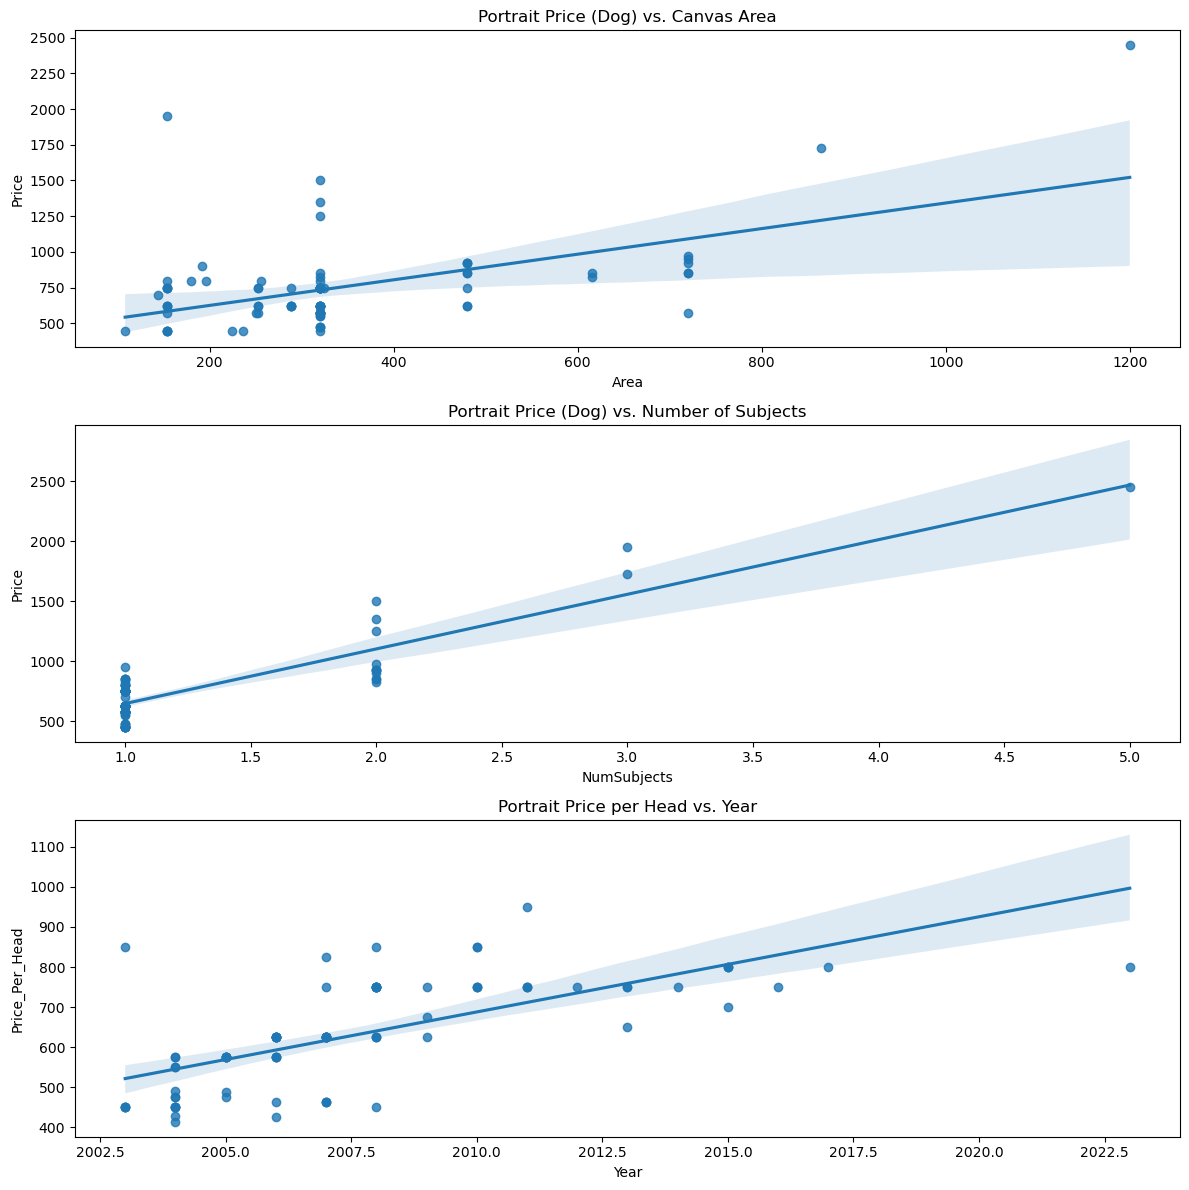

In [35]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

sns.regplot(
    x='Area',
    y='Price',
    data=df_filtered,
    ax=axs[0]
)
axs[0].set_title('Portrait Price (Dog) vs. Canvas Area')

sns.regplot(
    x='NumSubjects',
    y='Price',
    data=df_filtered,
    ax=axs[1]
)
axs[1].set_title('Portrait Price (Dog) vs. Number of Subjects')

sns.regplot(
    x='Year',
    y='Price_Per_Head',
    data= df_filtered,
    ax=axs[2]
)
axs[2].set_title('Portrait Price per Head vs. Year')

plt.tight_layout()
plt.show()

Now we can try a multi variable linear regression.

In [36]:
#Fit linear regression to predict price using list of features
x1=df_filtered[['Year', 'Area', 'NumSubjects']]
y1=df_filtered['Price']
lre_multi=LinearRegression()
lre_multi.fit(x1, y1)
print('The R2 value is: ', lre_multi.score(x1,y1))

# Get the intercept
intercept = lre_multi.intercept_
print(f"The intercept is: {intercept}")

# Get the coefficients
coefficients = lre_multi.coef_

# Display the coefficients
for feature, coef in zip(x1.columns, coefficients):
    print(f"The coefficient for {feature} is {coef}")

The R2 value is:  0.8678301344450077
The intercept is: -52433.1759966182
The coefficient for Year is 26.194149928731722
The coefficient for Area is 0.12031041246223617
The coefficient for NumSubjects is 452.2857750676249


## Polynomial Regression
Although the curve fitting looks good, especially for Price vs NumSubjects, I want to examine whether we might get better results with polynomial curve fitting.

To that end, we'll try a training against a range of polynomial degrees and look at the root mean square error of each. Basically, we're looking to see what order of polynomial might be a good fit when we hold it up against an out-of-sample test set.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2)

In [38]:
def build_polynomial_models(X_train, y_train, X_test, y_test, max_degree):
    
    train_RMSE_list = []
    test_RMSE_list = []
 
    # runs from degree = 1 to max_degree
    for degree in range(1, max_degree+1):
 
        pipeline_steps = [
            ('poly', PolynomialFeatures(degree=degree)), 
            ('scaler', StandardScaler()), 
            ('regressor', LinearRegression())
        ]
        pipeline = Pipeline(steps=pipeline_steps)
 
        # train the model using X_train and y_train
        pipeline.fit(X_train, y_train)
 
        # Predict output for X_train 
        train_predictions = pipeline.predict(X_train)    
        train_RMSE = mean_squared_error(y_train, train_predictions)**0.5
        train_RMSE_list.append(train_RMSE)
 
        # Predict output for X_test (unseen data)
        test_predictions = pipeline.predict(X_test)    
        test_RMSE = mean_squared_error(y_test, test_predictions)**0.5
        test_RMSE_list.append(test_RMSE)
    
    error_df = pd.DataFrame(
        {'Training RMSE': train_RMSE_list, 'Test RMSE': test_RMSE_list}, 
        index=range(1, max_degree+1)
    )
    error_df.index.name = 'Degree'  
    
    return error_df

In [39]:
error_df = build_polynomial_models(X_train,y_train,X_test,y_test,5)

In [40]:
error_df.round(2)

,Training RMSE,Test RMSE
Degree,,
1,113.41,113.73
2,95.81,100.76
3,77.38,116.74
4,51.66,6348.54
5,40.63,319088.96


The results show that the polynomial rapidly becomes overfit at third order and higher. We can visualize that by plotting the training RMSE against the test RMSE.

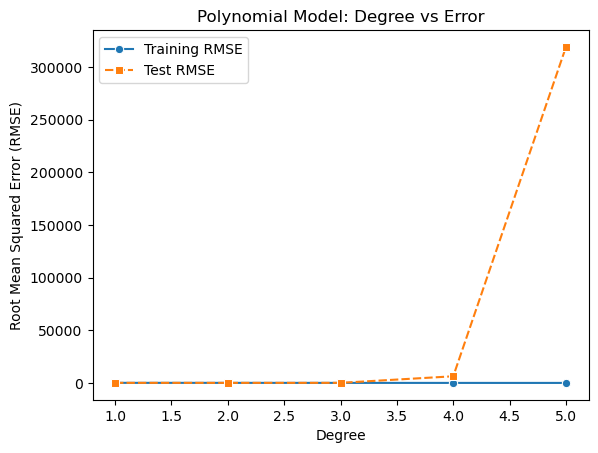

In [41]:
# Plot up to degree 5. Including higher degrees will expand the 
# y scale dramatically, visually squeezing RMSE for lower degrees    
sns.lineplot(data=error_df.loc[:5], markers=['o', 's'])
 
plt.title('Polynomial Model: Degree vs Error')
plt.xlabel("Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.show()

Would a third order polynomial give us a good prediction of Price_Per_Head for a given Year? Could we use this to price a portrait in the future?

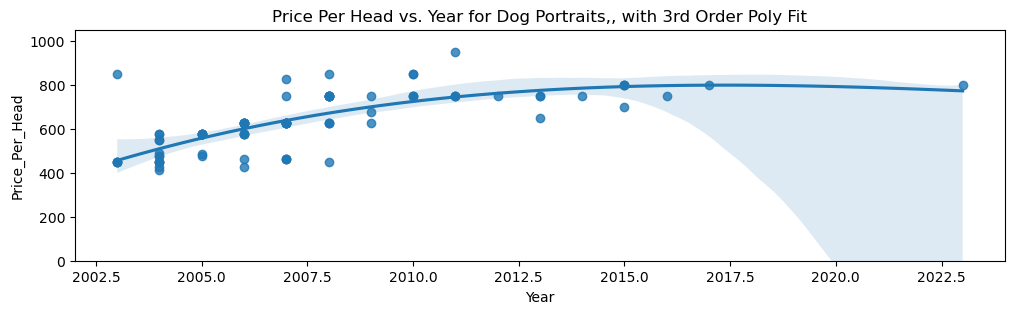

In [51]:
plt.figure(figsize=(12,3))
sns.regplot(data=df_filtered, x="Year", y="Price_Per_Head", order=3)

# Set y-axis limits to start at 0
plt.ylim(0, None)

plt.title('Price Per Head vs. Year for Dog Portraits,, with 3rd Order Poly Fit')

plt.show()

In general, we can see that the polynomial is better than simple linear regression at correlating the Price_Per_Head vs. Year for our existing data. Clearly, the sparse portrait data after 2019 (thanks, COVID!), makes fitting in this time period and projections into the future a major challenge. By the way, a fourth order curve also fits well, but has some signs of oscillation that indicate the start of an overfit to the training data.

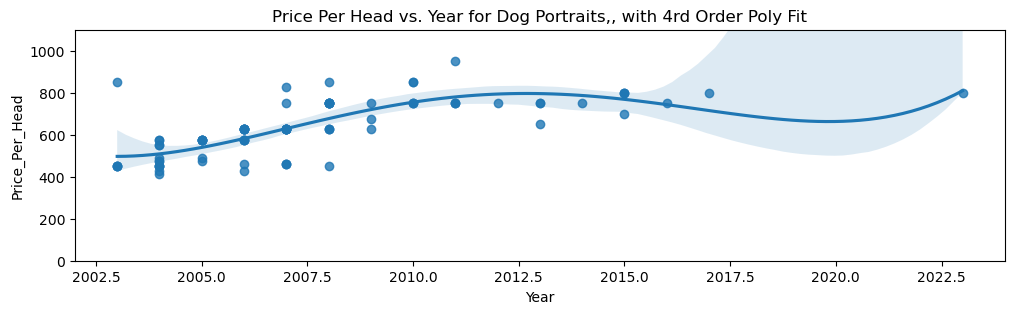

In [48]:
plt.figure(figsize=(12,3))
sns.regplot(data=df_filtered, x="Year", y="Price_Per_Head", order=4)

# Set y-axis limits to start at 0
plt.ylim(0, 1100)

plt.title('Price Per Head vs. Year for Dog Portraits,, with 4rd Order Poly Fit')

plt.show()